In [1]:
import functools
from typing import Callable, Dict, List, Tuple, Union

import empyrical as ep
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from alphalens.tears import GridFigure
from scr.activation_funcs import Exp, ReLU, identity, sign, tanh
from scr.binary_operators import (
    Corr,
    get_x,
    get_y,
    operators_add,
    operators_diff,
    operators_max,
    operators_min,
    operators_multiple,
    x_is_greater_than_y,
)
from scr.TC import Company, Trader
from sklearn import mixture
from tqdm.notebook import tqdm

plt.rcParams["font.sans-serif"] = ["SimHei"]  # 设置字体
plt.rcParams["axes.unicode_minus"] = False  # 该语句解决图像中的“-”负号的乱码问题

d:\anaconda3\lib\site-packages\empyrical\utils.py:32: UserWarning: Unable to import pandas_datareader. Suppressing import error and continuing. All data reading functionality will raise errors; but has been deprecated and will be removed in a later version.
  warnings.warn(msg)


# 交易员

"交易员"代表了一系列上述 Alpha 的叠加,定义如下:
$$\hat{r_{i}[t+1]}=\sum^{M}_{j=1}w_{j}A_{j}(O_{j}(r_{P_{j}}[t-D_{j}],r_{Q_{j}}[t-F_{j}])) \tag{Eq.1}$$

其中：
- M为交易员所拥有的Alpha数（或其参考的指标数）； 
- $W_{j}$为每一指标的权重； $A_{j}$为该项的激活函数，$A_{j}(x)$表达式可为 x, tanh(x), exp(x), sign(x), ReLU(x)等； 
- $O_{𝑗}$为二元操作符，$𝑂_{𝑗}(𝑥, 𝑦)$表达式可为 x+y, x-y, xy, x, y, max(x,y), min(x,y), x>y, x<y,Corr(x,y); 
- $𝑃_{𝑗}$、$𝑄_{𝑗}$为该项所参考的股票标识，$𝐷_{𝑗}$、$𝐹_{𝑗}$为相应的延迟参数。
- $\theta$代表上述一系列超参数。

|参数|参数解释|取值|
|--|--|--|
|M|每位交易员表达式最大项数,见Eq.1|10|
|$A_{j}(x)$|每一项的激活函数,见Eq.1|x, tanh(x), exp(x),sign(x), ReLU(x)|
|$O_{j}(x)$|一项的二元操作符，见 Eq.1|x+y, x-y, xy, x, y, max(x,y), min(x,y), x>y, x<y,Corr(x,y)|
|$P_{j}$,$Q_{j}$|为预测第j只股票下一期收益所参考的股票|参考股票池内的所有股票|
|$F_{j}$,$D_{j}$|延迟参数,见Eq.1|整数𝑙~ 𝑚𝑎𝑥_𝑙𝑎𝑔 + 𝑙,即 1~10|
|max_lag|数据延迟最大取值|10|
|l|交易延迟量，即观察到数据后不可能立马进行交易，需要再等待𝑙时间|1|
|N|一个投资公司所拥有的交易员数量|100|
|Q|每次投资公司对排名靠后的 Q% 名交易员进行教育或淘汰|50%|
|time_window|投资公司在教育或淘汰交易员时，参考 其过去 time_window时间段内的累积收益|100|

# 投资公司

由于所有Alpha的超额收益均为短暂的，且没有交易员能长期持续跑赢市场，因此 参照现实市场引入“投资公司”这一角色。对于一家拥有N个交易员的投资公司，其最终形成的投资决策需要综合反应 N个交易员的观点。记第n个交易员对第i只股票t+1 时刻收益率的预测值为$\hat{r}^{n}_{i}[t+1]$ ,则投资公司对第i只股票t+1时刻的预测值可形式化地表示为：
$$\hat{r}_{i}=Aggregate(\hat{r}^{1}_{i}[t+1],\dots,\hat{r}^{n}_{i}[t+1],\dots,\hat{r}^{N}_{i}[t+1]) \tag{Eq.2}$$

其中𝐴𝑔𝑔𝑟𝑒𝑔𝑎𝑡𝑒可通过计算
1. N 个交易员预测的平均值，
2. 一段时间内预测准 确率前 50%的交易员的预测平均值
3. 通过神经网络等对交易员预测值进行训练等。

交易员过去一段时间的历史业绩通过以下方式计算：
$$C_{i}[t]=\sum^{t}_{u=0}sign(\hat{r}_{i}[u+1]*r_{i}[u+1]) \tag{Eq.3}$$

其中$C_{i}[t]$为交易员t时间段内的累积业绩，$\hat{r}_{i}[u+1]$为u+1时刻的预测收益率，sign()为符号函数，$\hat{r}_{i}[u+1]$为u+1时刻的实际收益率。当交易员预测 t+1时刻收益率为正时， 以 t 时刻收盘价买入，并在 t+1时刻收盘价卖出；当交易员预测 t+1时刻收益率为负时， 以 t时刻收盘价卖出，并在 t+1时刻收盘价买回。交易员方向预测准确时获得正收益，方 向预测错误时获得负收益，其获取的收益大小仅取决于市场涨跌幅，与预测值本身大小 无关。
投资公司定期对交易员一段时间内的预测准确率进行复盘跟踪，对排名靠后的交易员进行“教育”（即使用最小二乘法优化表达式Eq.1中的权重）。 如交易员被“教育”后仍然表现不佳，则将其淘汰，并基于表现较好的交易员产生新的交易员：以过去一段时间业绩较好的交易员拟合高斯混合分布，并从中抽样产生新晋交易员的参数。对上述过程进行重复迭代即完整的“交易员-投资公司”交易策略模型。

# 一些关键性结论

>First, the pruning step seems quite important (cf. TC w/o prune). Regarding the scores for the pruning, using the MSE instead of the cumulative returns dete-riorates the performance (cf. TC MSE). Second, we can see that introducing the education step also improves the overall performance (cf. TC w/o educate). Otherwise Companies may discard Traders that have possibly good formulae. Lastly, using multimodal distribution in the generation step (Algorithm 3) is quite important.If we instead use a unimodal distribution (cf. TC unimodal), the performance is substantially deteriorated. A possible reason is that a unimodal distribution concentrates around the means of discrete indices, which does not make sense.

# 复现测试

In [2]:
# 基础参数
activation_funcs: List[Callable] = [identity, ReLU, sign, tanh]
binary_operators: List[Callable] = [
    operators_max,
    operators_min,
    operators_add,
    operators_diff,
    get_x,
    get_y,
    operators_multiple,
    x_is_greater_than_y,
]

# 读取储存数据
price = pd.read_csv('Data\data.csv',index_col=[0],parse_dates=[0])

def plot_cum_returns(returns:pd.DataFrame,ax=None,title:str=''):
      
      if ax is None:
            fig,ax = plt.subplots(figsize=(18,6))
      
      cum_returns:pd.DataFrame = ep.cum_returns(returns)
      cum_returns.plot(color=['darkgray','red'],ax=ax,title=title)
            
      return ax

def get_backtesting(params: Dict, data: pd.DataFrame, target_name: str,without_target:bool=False) -> pd.DataFrame:

      codes: List = data.columns.tolist()
      if without_target:
            test_col:List = codes
      else:
            test_col: List = [i for i in codes if i != target_name]

      train_data: np.ndarray = data[test_col]
      target: np.ndarray = data[target_name]

      company = Company(**params)

      company.fit(train_data.values, target.values)

      time_window: int = params['time_window']-1
      benchmark: pd.Series = target.iloc[time_window:]

      sign: np.ndarray = np.where(company.aggregate > 0, 1, 0)
      returns: pd.Series = benchmark.shift(-1) * sign
      df: pd.DataFrame = pd.concat((benchmark, returns), axis=1)
      df.columns = ['benchmark', target_name]

      return df

## BayesianGaussianMixture生成迭代参数

TC模型:   0%|          | 0/2858 [00:00<?, ?it/s]

<AxesSubplot:title={'center':'BayesianGaussianMixture_ACC_Q'}>

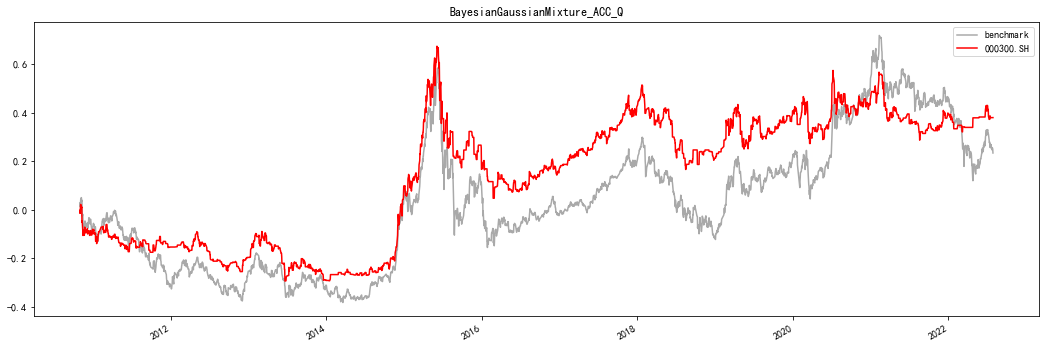

In [3]:
codes: List = price.columns.tolist()
target_name = '000300.SH'
params = {'trader_num': 100, 
            'A': activation_funcs,
            'O':binary_operators, 
            'stock_num': len(codes) - 1, 
            'M': 10,
            'max_lag': 9, 
            'l': 1,
            'time_window':100, 
            'Q': 0.5, 
            'generate_method': 'BayesianGaussianMixture',
            'evaluation_method':'ACC',
            'aggregate_method':'Q', 
            'seed':None}

# 5m-28.7
ret1:pd.DataFrame = get_backtesting(params,price,target_name,True)
plot_cum_returns(ret1,title='BayesianGaussianMixture_ACC_Q')

## GaussianMixture生成迭代参数

TC模型:   0%|          | 0/2858 [00:00<?, ?it/s]

<AxesSubplot:title={'center':'GaussianMixture_ACC_Q'}>

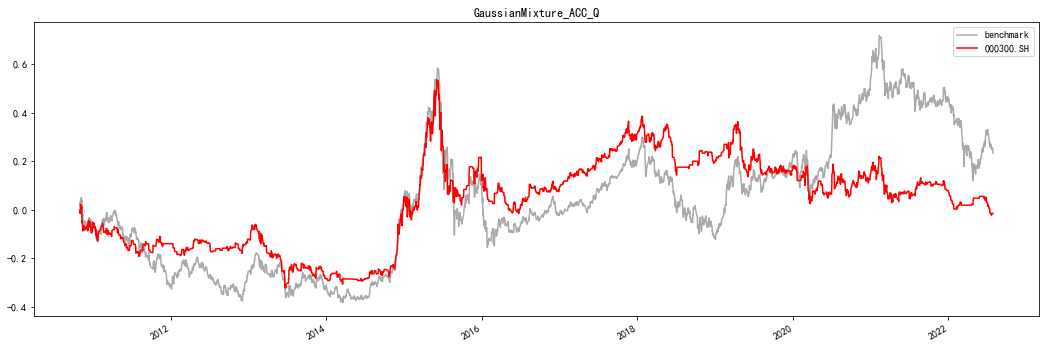

In [4]:
codes: List = price.columns.tolist()

params = {'trader_num': 100, 
            'A': activation_funcs,
            'O':binary_operators, 
            'stock_num': len(codes) - 1, 
            'M': 10,
            'max_lag': 9, 
            'l': 1,
            'time_window':100, 
            'Q': 0.5, 
            'generate_method': 'GaussianMixture',
            'evaluation_method':'ACC',
            'aggregate_method':'Q', 
            'seed':None}

ret2:pd.DataFrame = get_backtesting(params,price,target_name,True)
plot_cum_returns(ret2,title='GaussianMixture_ACC_Q')

## Gaussian分布生成迭代参数

TC模型:   0%|          | 0/2858 [00:00<?, ?it/s]

<AxesSubplot:title={'center':'Gaussian_ACC_Q'}>

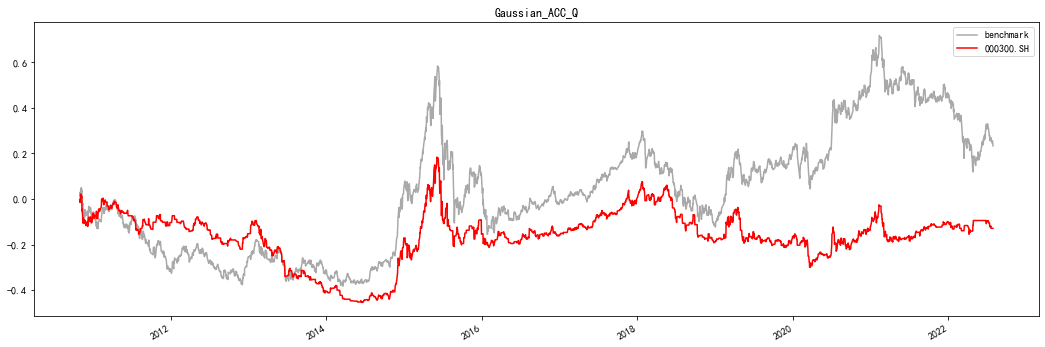

In [5]:
codes: List = price.columns.tolist()

params = {'trader_num': 100, 
            'A': activation_funcs,
            'O':binary_operators, 
            'stock_num': len(codes) - 1, 
            'M': 10,
            'max_lag': 9, 
            'l': 1,
            'time_window':100, 
            'Q': 0.5, 
            'generate_method': 'Gaussian',
            'evaluation_method':'ACC',
            'aggregate_method':'Q', 
            'seed':None}

ret3:pd.DataFrame = get_backtesting(params,price,target_name,True)
plot_cum_returns(ret3,title='Gaussian_ACC_Q')